# Imports

## For plots

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

## Imports from standard packages

In [2]:
import numpy as np
# from scipy.interpolate import interp1d
from astropy.io import fits
# from astropy.convolution import convolve, Box1DKernel

## Local imports

In [3]:
# from extract.overlap import TrpzOverlap
# from extract.utils import grid_from_map, get_soss_grid, oversample_grid

# Read ref files

In [4]:
# Read relevant files
wv_1 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/wavelengths_m2.fits")[0].data
P1 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/spat_profile_m1.fits")[0].data.squeeze()
P2 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/spat_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

<IPython.core.display.Javascript object>


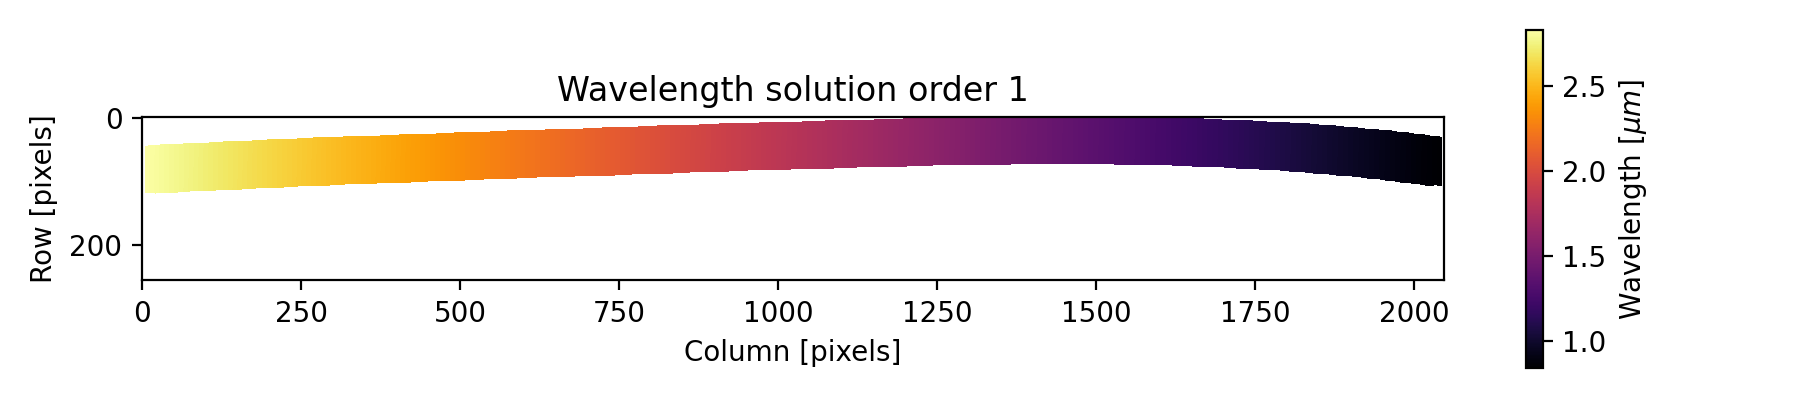

<IPython.core.display.Javascript object>


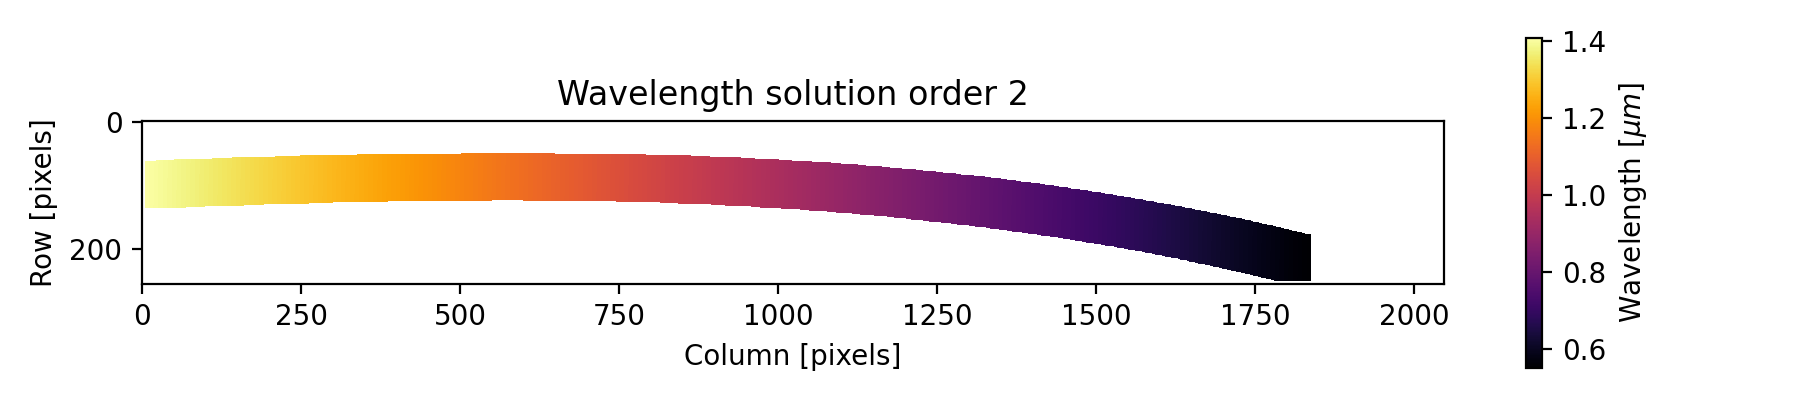

<IPython.core.display.Javascript object>


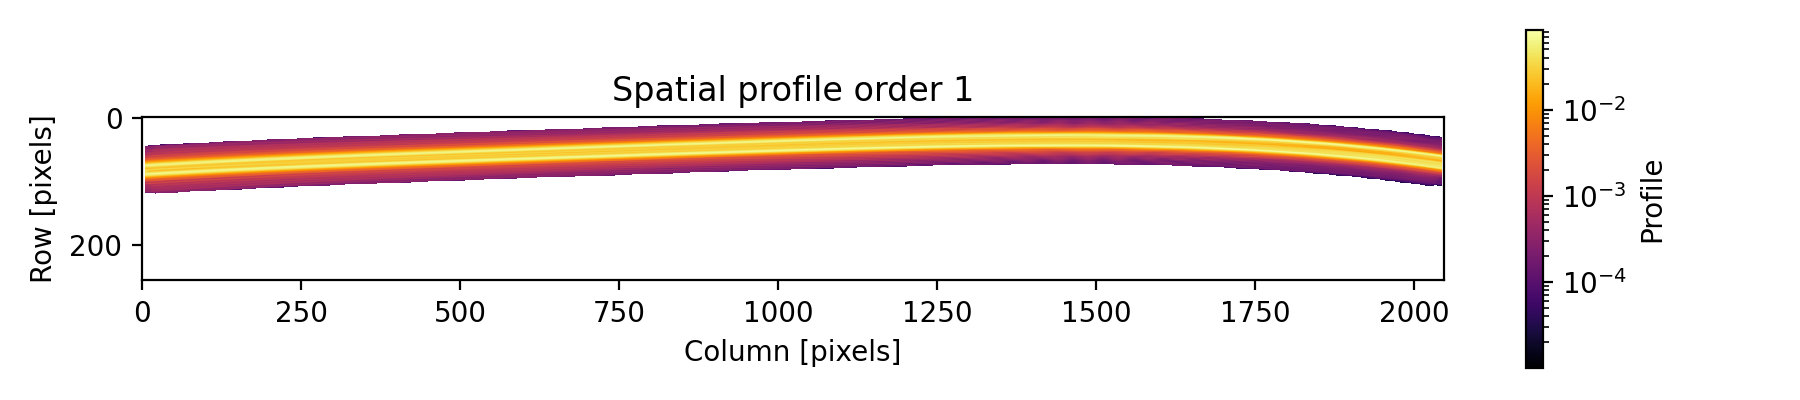

<IPython.core.display.Javascript object>


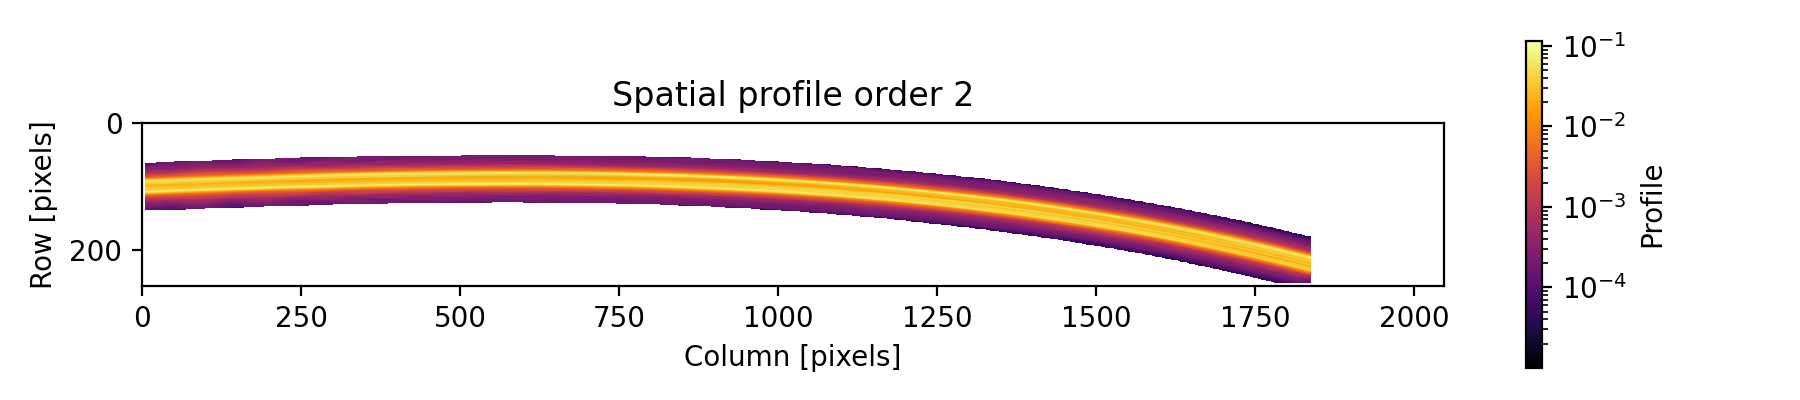

In [5]:
plt.figure(figsize=(9,2))
plt.title("Wavelength solution order 1")
plt.imshow(np.ma.array(wv_1, mask=P1<0.00001))
cmap = plt.colorbar(label="Wavelength [$\mu m$]")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Wavelength solution order 2")
plt.imshow(np.ma.array(wv_2, mask=(P2<0.00001)|(wv_2==0)))
cmap = plt.colorbar(label="Wavelength [$\mu m$]")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Spatial profile order 1")
plt.imshow(np.ma.array(P1, mask=P1<0.00001), norm=LogNorm())
cmap = plt.colorbar(label="Profile")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Spatial profile order 2")
plt.imshow(np.ma.array(P2, mask=(P2<0.00001)|(wv_2==0)), norm=LogNorm())
cmap = plt.colorbar(label="Profile")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

## Load simulation


In [6]:
from simulation_utils import load_simu
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

In [7]:
simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e-01.fits")

In [8]:
simu

{'grid': array([0.55028933, 0.5503206 , 0.55035187, ..., 2.99896924, 2.99903714,
        2.99910505]),
 'f_k': array([5.47552198e+08, 5.65706494e+08, 5.99460040e+08, ...,
        8.82420119e+10, 9.10482248e+10, 8.44387364e+10]),
 'grid_c1': array([0.83615988, 0.83619105, 0.83622223, ..., 2.83632606, 2.83639357,
        2.83646109]),
 'f_c1': array([1.66177774e+11, 1.66553688e+11, 1.66874551e+11, ...,
        9.89544931e+10, 9.91255192e+10, 9.92610758e+10]),
 'grid_c2': array([0.5529112 , 0.55294192, 0.55297263, ..., 1.41168005, 1.4117111 ,
        1.41176256]),
 'f_c2': array([1.59682324e+09, 1.60572746e+09, 1.61228099e+09, ...,
        4.61412818e+11, 4.65448632e+11, 4.71135692e+11]),
 'data': array([[ 5.33566139e+00, -1.45747573e+00,  1.29358574e+01, ...,
         -1.17365648e+01,  5.07462995e-01, -1.95582596e+01],
        [ 3.11834523e+00,  2.24363377e+00,  1.53844288e+01, ...,
          2.43525518e+01,  9.33450625e+00, -1.49648897e+00],
        [-3.37771765e+01, -1.05992455e+01,  5

# Figure 2

In [12]:
norm = np.max(simu["f_k"])
for key in ['f_c1', 'f_c2', "f_k"]:
    simu[key] /= norm

<IPython.core.display.Javascript object>


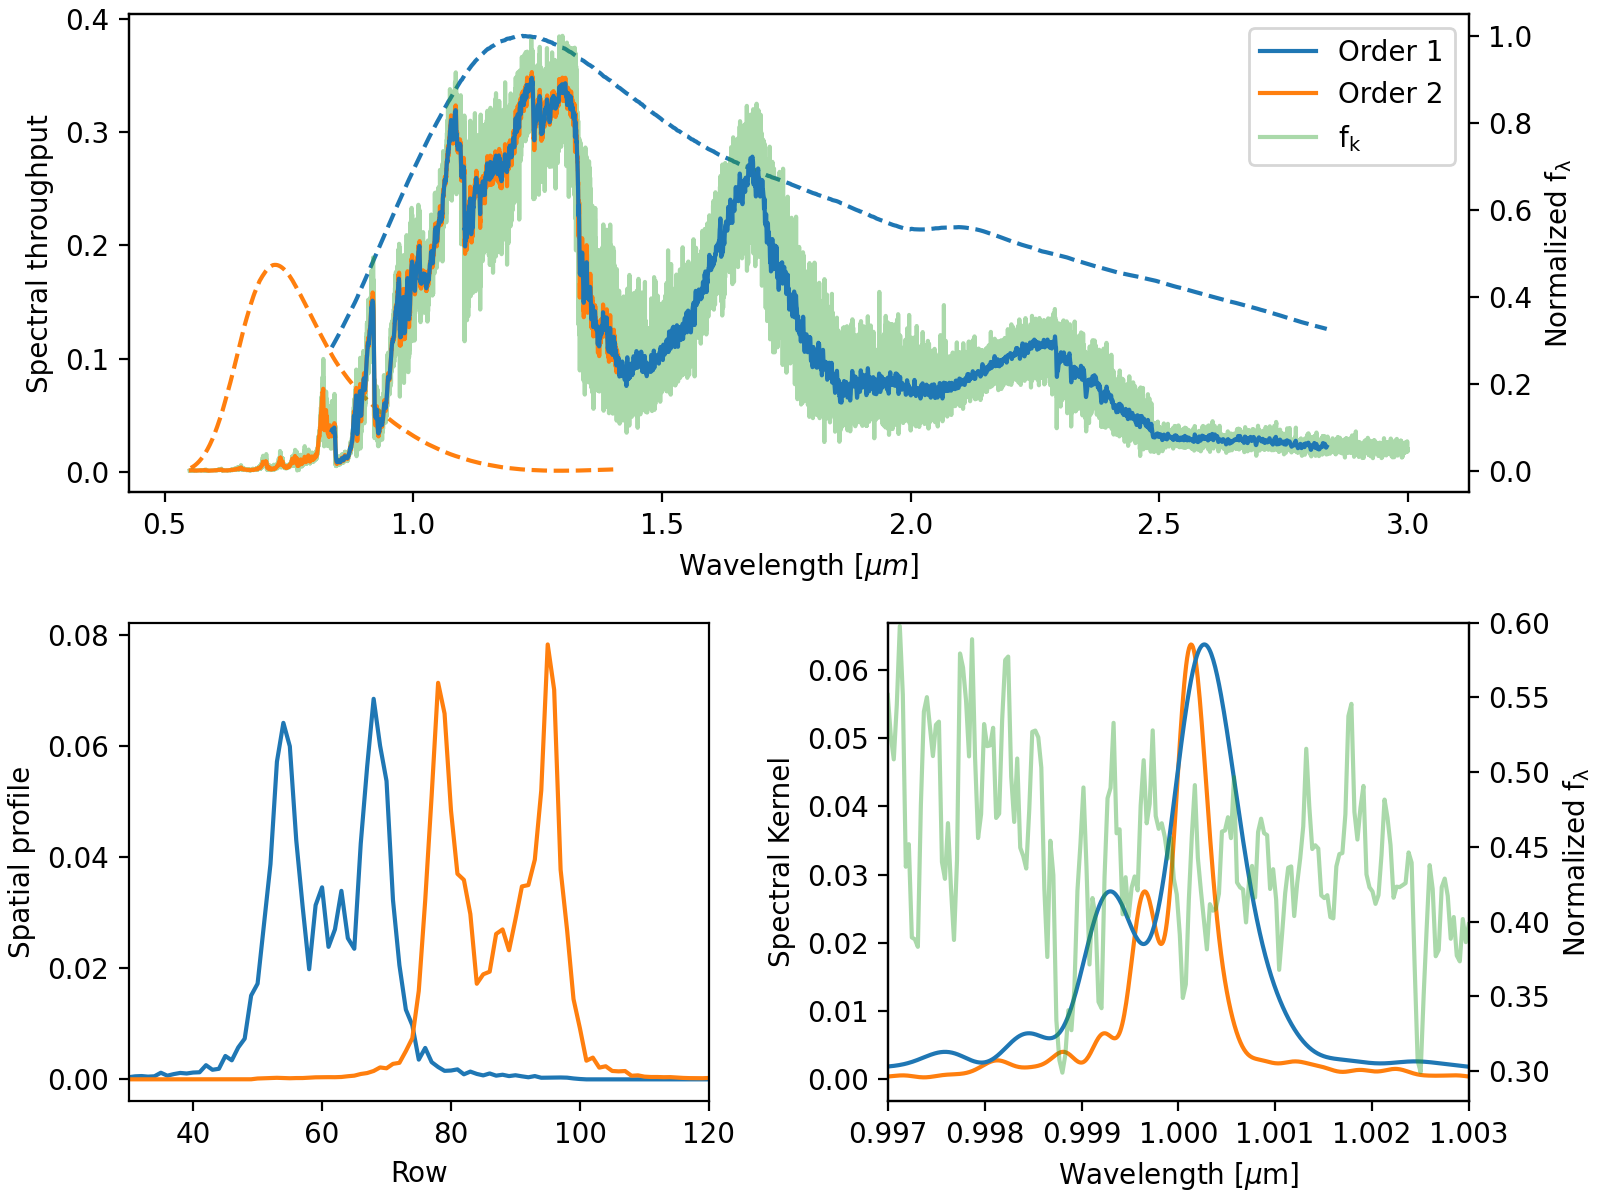

In [90]:
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = fig.add_gridspec(2, 2)

#### Top panel #####

ax1 = fig.add_subplot(gs[0, :])

ax1.plot(simu['grid_c1'], ThroughputSOSS(1)(simu['grid_c1']), "--")
ax1.plot(simu['grid_c2'], ThroughputSOSS(2)(simu['grid_c2']), "--")

ax_twin = ax1.twinx()
ax_twin.plot('grid_c1', 'f_c1', data=simu, zorder=2, label="Order 1")
ax_twin.plot('grid_c2', 'f_c2', data=simu, zorder=1, label="Order 2")
ax_twin.plot('grid', 'f_k', data=simu, alpha=0.4, zorder=0, label="$\mathrm{f_k}$")
ax_twin.legend()
ax1.set_ylabel("Spectral throughput")
# ax_twin.set_ylabel(r"$\mathrm{f_\lambda}$ [$\frac{erg}{s \cdot cm^2 \cdot \mu m}$]")
ax_twin.set_ylabel(r"Normalized $\mathrm{f_\lambda}$")
ax1.set_xlabel("Wavelength [$\mu m$]")

#### Bottom right ####

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(P1[:,500], label="Order 1")
ax2.plot(P2[:,500], label="Order 2")
ax2.set_xlabel("Row")
ax2.set_ylabel("Spatial profile")
# ax2.legend()
ax2.set_xlim(30, 120)

#### Bottom left

ax3 = fig.add_subplot(gs[1, 1])

wv_c = 1
wv_shift = np.arange(-0.01, 0.01, 0.00001)
n_wv = len(wv_shift)

ker = WebbKer(wv_1)
ax3.plot(wv_c + wv_shift, ker(wv_c + wv_shift, np.repeat(wv_c, n_wv)))

ker = WebbKer(wv_2)
ax3.plot(wv_c + wv_shift, ker(wv_c + wv_shift, np.repeat(wv_c, n_wv)), zorder=0)

color_f_k = ax_twin.get_lines()[-1].get_color()
ax_twin = ax3.twinx()
ax_twin.plot('grid', 'f_k', data=simu, alpha=0.4, zorder=0, color=color_f_k)
    
ax3.set_xlim(0.997, 1.003)
ax_twin.set_ylim(0.28, 0.6)
ax_twin.set_ylabel(r"Normalized $\mathrm{f_\lambda}$")

ax3.set_xlabel("Wavelength [$\mu$m]")
ax3.set_ylabel("Spectral Kernel")

plt.show()

# Figure 3

In [244]:
from extract.overlap import TrpzOverlap
from extract.utils import get_lam_p_or_m
from scipy.interpolate import interp1d

In [97]:
# Parameters for extraction
n_os = 4
c_thresh = 1e-5
# t_mat_n_os = 2

In [247]:
extra = TrpzOverlap([P1, P2], [wv_1, wv_2], scidata=simu['data'],
                    n_os=n_os, thresh=1e-5,
                    c_kwargs={'thresh': c_thresh})

<IPython.core.display.Javascript object>


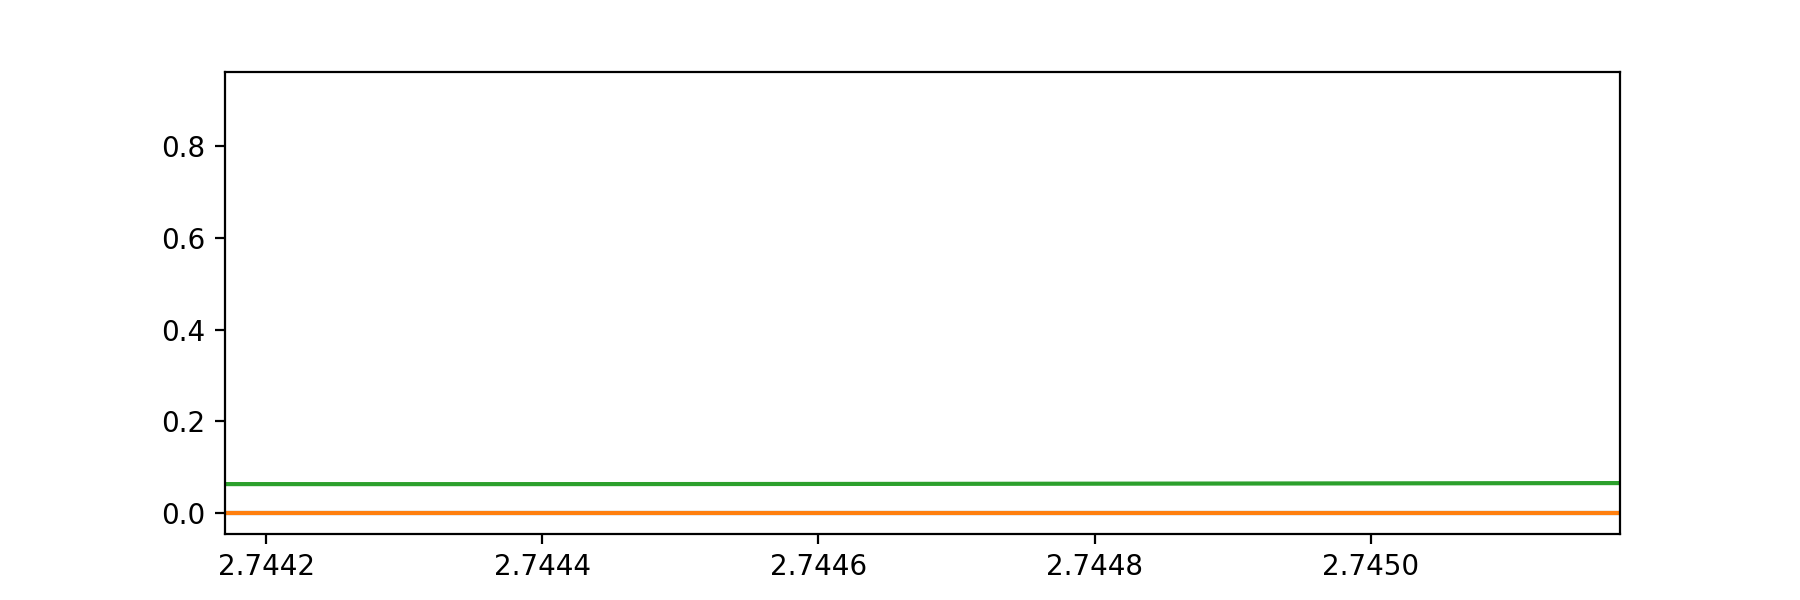

In [106]:
plt.plot(P1[:,70], label="Order 1")
plt.plot(P2[:,70], label="Order 2")

<IPython.core.display.Javascript object>


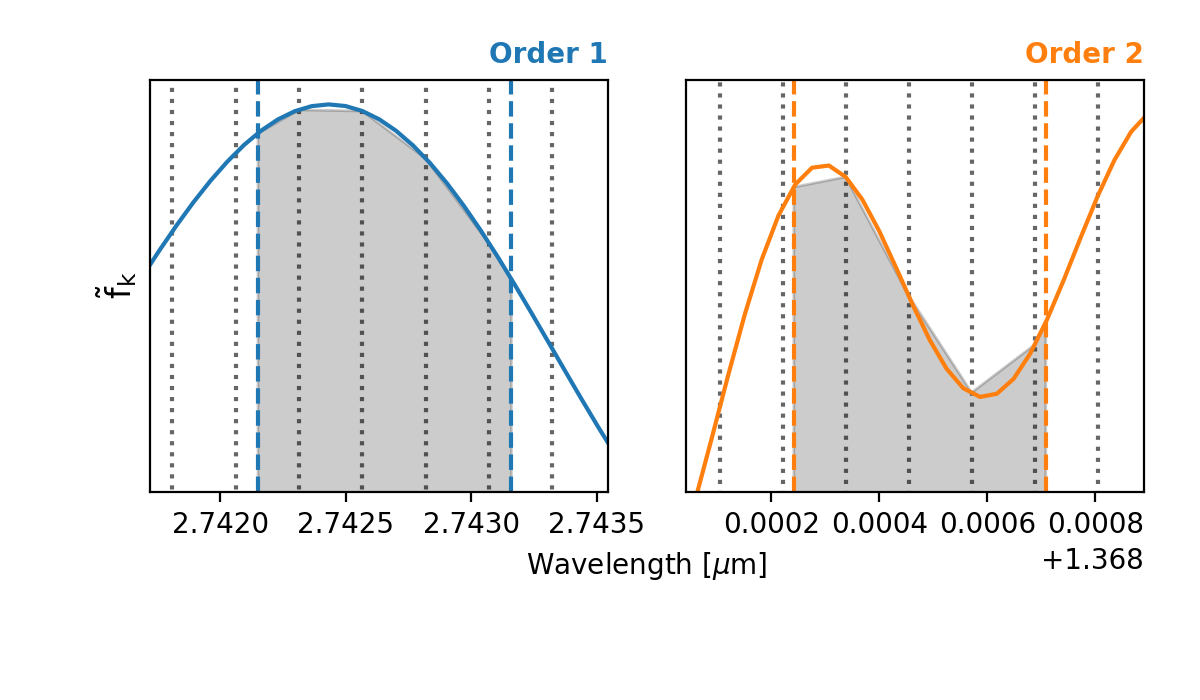

In [232]:
row, col = (70, 92)


fig, ax = plt.subplots(1, 2, figsize=(6,3.5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i_ord, wv_map in enumerate([wv_1, wv_2]):
    
    
    # Convolved spectrum
    lam_p, lam_m = get_lam_p_or_m(wv_map)
    x2, x1 = lam_p[row, col-1], lam_m[row, col+1]
    x = simu[f'grid_c{i_ord+1}']
    y = simu[f'f_c{i_ord+1}']
    f_c = interp1d(x, y)
    i_wv = (x1 < x) & (x < x2)
    ax[i_ord].plot(x[i_wv], y[i_wv], color=colors[i_ord], label=f"Order {i_ord+1}")
    ax[i_ord].set_ylim(0, None)
    
    # Plot pixel
    ax[i_ord].axvline(lam_p[row, col], linestyle="--", color=colors[i_ord])
    ax[i_ord].axvline(lam_m[row, col], linestyle="--", color=colors[i_ord])
    
    # Plot grid
    grid = extra.lam_grid
    i_wv = (x1 < grid) & (grid < x2)
    ax[i_ord].vlines(grid[i_wv], *ax[i_ord].get_ylim(), zorder=0, linestyle=":", alpha=0.6)
    
    # Plot integral
    x2, x1 = lam_p[row, col], lam_m[row, col]
    i_wv = (x1 < grid) & (grid < x2)
    x = np.concatenate([[x1], grid[i_wv], [x2]])
    x = np.sort(x)
    y = f_c(x)
    ax[i_ord].fill_between(x, 0, y, color='k', alpha=0.2)
    
    # Adjust x limits
    x_lim = np.array(ax[i_ord].get_xlim())
    x0 = np.mean(x_lim)
    dx = np.diff(x_lim) * 0.56
    ax[i_ord].set_xlim(x0 - dx/2, x0 + dx/2)
    
#     ax[i_ord].legend(loc=1, fontsize="small")
    ax[i_ord].set_title(f"Order {i_ord+1}", loc="right",
                        fontsize="medium", color=colors[i_ord], fontweight="bold")

ax[0].set_ylim(0.065, None)
ax[1].set_ylim(0.32, None)

ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].set_ylabel(r"$\mathrm{\tilde{f}_k}$", fontsize="large")
# ax[1].set_ylabel(r"$\mathrm{\tilde{f}_k}$ order 2")

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.xlabel("Wavelength [$\mu$m]")

plt.tight_layout()